# Figure 2

In [52]:
import NotebookImport
from DX_screen import *

In [53]:
cd ../DX/Notebooks/

[Errno 2] No such file or directory: '../DX/Notebooks/'
/cellar/users/agross/TCGA_Code/DX/Notebooks


In [54]:
def plot_HR(ci, colors=None, ax=None):
    _, ax = init_ax(ax)
    if colors is None:
        colors = ['grey'] * ci.shape[0]
    ci = np.log2(ci)
    for i,(h,v) in enumerate(ci.iterrows()):
        ax.scatter(v['exp(coef)'], i, marker='s', s=50, color=colors[i], 
                   edgecolors=['black'], zorder=10)
        ax.plot((v['lower .95'],v['upper .95']), (i,i), 
                    lw=1.7, ls='-', marker='o', dash_joinstyle='bevel', 
                color=colors[i])
    prettify_ax(ax)
    ax.set_ybound(-.5, i + .5)
    ax.set_yticks(range(i+1))
    ax.set_yticklabels(ci.index)
    ax.axvline(0, ls='--', lw=2, color='grey', zorder=-1)
    ax.set_xticklabels(2.**ax.get_xticks())

In [55]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

Pull in log-hazard ratios from stratified pan-cancer survival screen

In [56]:
pancan_haz = pd.read_csv('r_pancan.csv', header=None, 
                         index_col=0, squeeze=True)

RNA proliferation signature

In [57]:
rna_sig = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                      index_col=[0,1], header=None, squeeze=True)
rna_sig = rna_sig[:,1]
rna_sig.index.name = ''

In [58]:
f = rna_sig.copy()
f = (f - f.mean()) / f.std()
f.name = 'feature'
codes_f = codes.ix[(codes.index.intersection(f.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
codes_f.name = 'codes'
m = get_cox_ph(surv_5y, f, [age, old, stage, codes_f], 
               print_desc=False, interactions=False)
ci = convert_robj(robjects.r.summary(m)[7])
ci.index = ci.index.map(lambda s: s.replace('codes', ''))
ci.index = ci.index.map(lambda s: s.replace('stagestage', 'stage'))
pancan_ci = ci.ix['feature']
pancan_ci.name = 'PANCAN'

In [59]:
v = rna_sig
ci = {}
for c in codes.unique():
    try:
        pts = ti(codes == c)
        f = v.ix[pts].dropna()
        cov = [b.ix[pts].dropna() for b in [old, age] if 
               b.ix[pts].dropna().unique().shape[0] > 1]
        f = (f - f.mean()) / f.std()
        f.name = 'featue'
        ff = ' + '.join(['feature'] + [b.name for b in cov])
        formula = robjects.Formula('Surv(days, event) ~ ' + ff)
        m1 = get_cox_ph(surv_5y, f, covariates=cov, formula=formula,
                        print_desc=False, interactions=False);
        ci[c] = convert_robj(robjects.r.summary(m1)[7])
    except:
        print c
cc = pd.concat(ci).xs('feature', level=1)
cc = cc.sort('exp(coef)', ascending=False)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]

STAD
ESCA
LAML


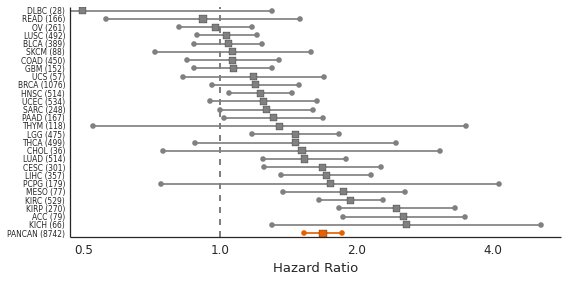

In [60]:
fig, ax = subplots(figsize=(8,4))
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label, fontsize=7.5);
ax.set_xlabel('Hazard Ratio')
fig.tight_layout()

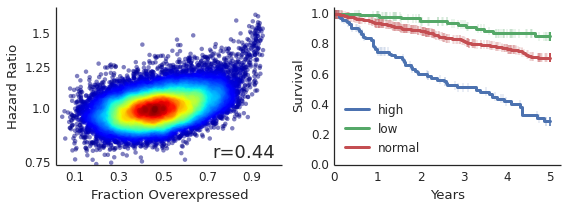

In [61]:
fig, axs = subplots(1,2, figsize=(8,3))
ax = axs[0]
f = dx_rna.frac
plot_regression(f - .5, pancan_haz, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ybound(-.3,.55)
ax.set_yticks(np.log([.75, 1, 1.25, 1.5]))
ax.set_yticklabels(np.round(np.exp(ax.get_yticks()), 2))
ax.set_ylabel('Hazard Ratio')
ax.set_xticklabels(ax.get_xticks() + .5)
ax.set_xlabel('Fraction Overexpressed')

ax = axs[1]
pts = ti(codes.str.startswith('K')).intersection(ti(age < 85))
draw_survival_curve(to_quants(rna_sig.ix[pts].dropna(), std=1, labels=True), 
                    surv_5y, ax=ax)
prettify_ax(ax)
fig.tight_layout()

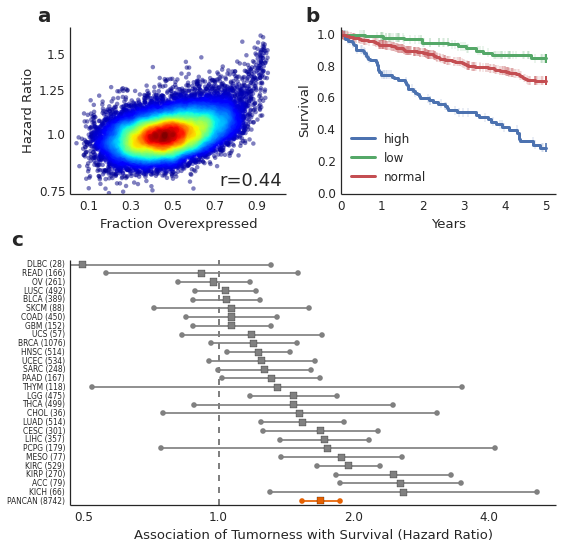

In [62]:
fig = plt.figure(figsize=(8, 7.5))
ax1 = plt.subplot2grid((7, 2), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((7, 2), (0, 1), rowspan=3)
ax3 = plt.subplot2grid((7, 2), (3, 0), colspan=2, rowspan=4)

ax = ax1
f = dx_rna.frac
plot_regression(f - .5, pancan_haz, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ybound(-.3,.55)
ax.set_yticks(np.log([.75, 1, 1.25, 1.5]))
ax.set_yticklabels(np.round(np.exp(ax.get_yticks()), 2))
ax.set_ylabel('Hazard Ratio')
ax.set_xticklabels(ax.get_xticks() + .5)
ax.set_xlabel('Fraction Overexpressed')

ax = ax2
pts = ti(codes.str.startswith('K')).intersection(ti(age < 85))
draw_survival_curve(to_quants(rna_sig.ix[pts].dropna(), std=1, labels=True), 
                    surv_5y, ax=ax)
prettify_ax(ax)

ax = ax3
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label, fontsize=7.5);
ax.set_xlabel('Association of Tumorness with Survival (Hazard Ratio)')

letters = list(map(chr, range(97, 123)))[:6] 
for i,ax in enumerate([ax1, ax2, ax3]):
    ax.text(-0.1, 1.12, letters[i], transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='right')
fig.tight_layout(pad=1.3, h_pad=3)
fig.savefig('/cellar/users/agross/Desktop/Figures/DX_fig2.png', dpi=300,
            bbox_inches='tight')